#### Transfer learning fine tunning

In [1]:
import tensorflow as tf
tf.random.set_seed(42)

In [2]:
!nvidia-smi

Wed Jun  2 09:34:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

`tf.keras.applications`

In [3]:
#get data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

import zipfile
zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-06-02 09:34:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   169MB/s    in 1.0s    

2021-06-02 09:34:35 (169 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
#checkout sub directories
import os

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 10 directori

In [5]:
BATCH_SIZE=32
IMAGE_SHAPE=(224,224)


In [6]:
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"


from tensorflow.keras.preprocessing import image_dataset_from_directory

train_data_10_percent=image_dataset_from_directory(train_dir,
                                                   image_size=IMAGE_SHAPE,
                                                   batch_size=BATCH_SIZE,
                                                   label_mode="categorical"
                                                   )

test_data=image_dataset_from_directory(test_dir,
                                                  image_size=IMAGE_SHAPE,
                                                  batch_size=BATCH_SIZE,
                                                  label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
type(train_data_10_percent)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np


In [11]:
for images , labels in train_data_10_percent.take(1):
  print(images[0].shape,labels[0])



(224, 224, 3) tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)


#### Tensorlow keras functional API

Keras function api is more flexible and able to produce more sophisticated models

#### Model 0 : building a transfer learning model using keras functional api

The sequential api is straight forward it runs model layers sequentially.

But functional api gives us more flexibility.

In [12]:
#create base line model
base_model=tf.keras.applications.EfficientNetB0(include_top=False)


#freeze layers
base_model.trainable=False

#create inputs to our model
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

#if you are using Resenet50v2 you will need to normalize input
#x=tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

x=base_model(inputs)
print("shape of input after going into base model",x.shape)

#average pool to reduce number of parameters
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

print(f"shape after global average pooling layer is :",x.shape)

#create output activation layer
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

#combine the inputs and outputs into model
model_0=tf.keras.Model(inputs,outputs)

#compile the model
model_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#fit the model
history_0=model_0.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=len(test_data))



16711680/16705208 [==============================] - 0s 0us/step
shape of input after going into base model (None, 7, 7, 1280)
shape after global average pooling layer is : (None, 1280)
Epoch 1/5
24/24 [==============================] - 43s 424ms/step - loss: 2.0015 - accuracy: 0.3027 - val_loss: 1.4339 - val_accuracy: 0.6312
Epoch 2/5
24/24 [==============================] - 9s 359ms/step - loss: 1.2024 - accuracy: 0.7200 - val_loss: 0.9689 - val_accuracy: 0.7776
Epoch 3/5
24/24 [==============================] - 9s 363ms/step - loss: 0.8834 - accuracy: 0.7773 - val_loss: 0.7798 - val_accuracy: 0.8148
Epoch 4/5
24/24 [==============================] - 9s 358ms/step - loss: 0.7027 - accuracy: 0.8453 - val_loss: 0.6808 - val_accuracy: 0.8292
Epoch 5/5
24/24 [==============================] - 9s 360ms/step - loss: 0.6031 - accuracy: 0.8533 - val_loss: 0.6218 - val_accuracy: 0.8384


In [13]:
#lets check layers in base model
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

#we can see keras input layer has rescaling and normalization layer built in

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


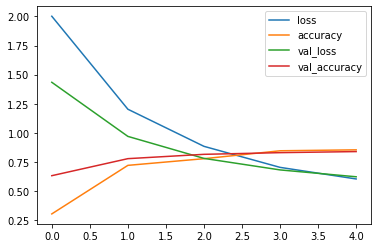

In [15]:
#checkout model loss curve
import pandas as pd
pd.DataFrame(history_0.history).plot()

#### Get feature vectors from trained model

In [17]:
input_shape=(1,4,4,3)
tf.random.set_seed(42)
#create tesnor
input_tensor=tf.random.normal(input_shape)
print(input_tensor)
#create global pooling layer
pooling_layer=tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(input_tensor)
print(pooling_layer)

tf.Tensor(
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]], shape=(1, 4, 4, 3), dtype=float32)
tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)


in above we can see input tensor of shape (1,4,4,3) is condensed into (1,3) along the ais 1 and 2.

We can also replicate this using reduce_mean function in tensorflow



In [18]:
tf.reduce_mean(input_tensor=input_tensor,axis=(1,2))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [19]:
tf.reduce_mean?

In [20]:
#lets see few more eamples
x = tf.constant([[1., 1.], [2., 2.]])
x

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [2., 2.]], dtype=float32)>

In [21]:
tf.reduce_mean(x,1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 2.], dtype=float32)>

In [22]:
tf.reduce_mean(x,0)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.5, 1.5], dtype=float32)>

Let's check `GlobalMaxPooling2D`

In [23]:
input_shape=(1,4,4,3)
tf.random.set_seed(42)
#create tensor same as above
tensor_input=tf.random.normal(input_shape)

print(input_tensor)
#create Max pooling layer
maxpooling_layer=tf.keras.layers.GlobalMaxPool2D(name="max_pooling_layer")(input_tensor)
print(maxpooling_layer)


tf.Tensor(
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]], shape=(1, 4, 4, 3), dtype=float32)
tf.Tensor([[0.9058464 1.1603122 1.6994323]], shape=(1, 3), dtype=float32)


Feature vectors: learned respresentation of input data based on how model see's it